<a href="https://colab.research.google.com/github/aminehd/Alice-Differentiable-Adventures/blob/main/Chapter_7/Conv_fft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Fourier Transform

Fourier transform converts a function to the frequency domain. In fact, it rewrites the function in terms of a new basis. The new basis functions are in the form of $e^{i(2\pi ux + 2\pi vy)}$.

Here I decided to demonstrate a 2D sinusoidal basis function for a given frequency. The output of `create_basis_function` represents these 2D sinusoidal functions.

The basis functions form the building blocks that, when combined with appropriate weights, can reconstruct any image. Each basis function is defined by its frequency parameters (u,v), which determine the number of oscillations in the horizontal and vertical directions.

In [29]:
import numpy as np
import matplotlib.pyplot as plt



# prompt: call def visualize_basis(u, v, M=64, N=64): for some few different inputs
import numpy as np
import matplotlib.pyplot as plt

def create_basis_function(u, v, M=64, N=64):
    """
    Creates a 2D sinusoidal basis function with frequency (u,v).

    Args:
        u, v: Frequency components
        M, N: Image dimensions

    Returns:
        The real part of the basis function (cosine wave)
    """
    # Create a grid of coordinates
    x = np.arange(M)
    y = np.arange(N)
    X, Y = np.meshgrid(x, y)

    # Calculate the real part (cosine wave)
    real_part = np.cos(2 * np.pi * (u * X / M + v * Y / N))

    return real_part


There is a neat way to illustrate 2D functions by showing their values on a 2D tensor. We can apply the given 2D function to each cell of a 2D tensor, and show a colored pixel representing the value of the function at that position. Below, I am showing the basis functions for different frequencies u v, so we can see the effect of frequencies on the visual patterns.


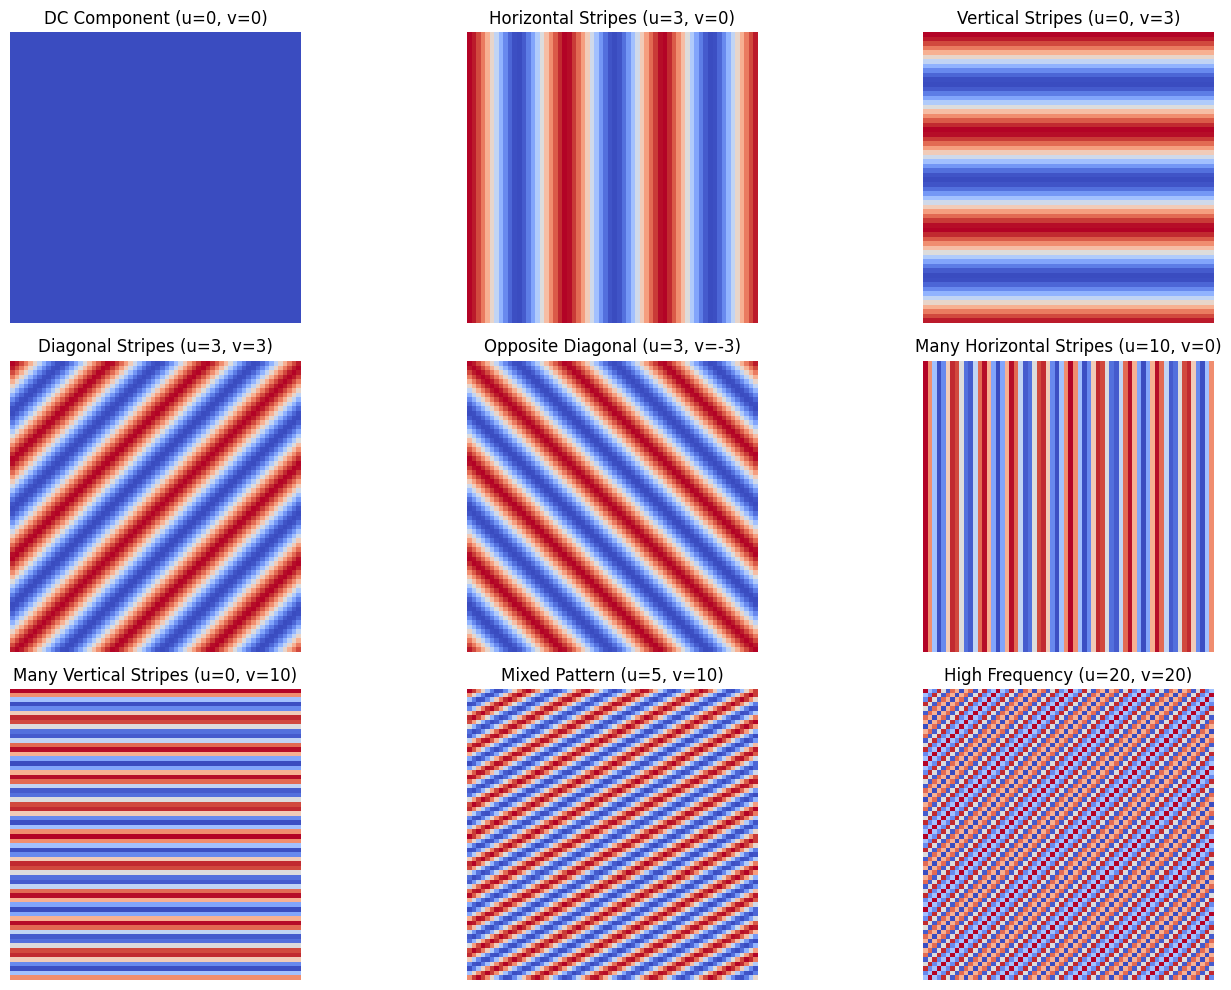

In [30]:

# Create a figure for basic examples
plt.figure(figsize=(15, 10))

# Define different frequency combinations to show
frequency_params = [
    (0, 0, "DC Component (u=0, v=0)"),
    (3, 0, "Horizontal Stripes (u=3, v=0)"),
    (0, 3, "Vertical Stripes (u=0, v=3)"),
    (3, 3, "Diagonal Stripes (u=3, v=3)"),
    (3, -3, "Opposite Diagonal (u=3, v=-3)"),
    (10, 0, "Many Horizontal Stripes (u=10, v=0)"),
    (0, 10, "Many Vertical Stripes (u=0, v=10)"),
    (5, 10, "Mixed Pattern (u=5, v=10)"),
    (20, 20, "High Frequency (u=20, v=20)")
]

for i, (u, v, title) in enumerate(frequency_params):
    plt.subplot(3, 3, i+1)
    basis = create_basis_function(u, v)
    plt.imshow(basis, cmap='coolwarm')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 4))
u_values = [1, 3, 6, 10, 15]
for i, u in enumerate(u_values):
    plt.subplot(1, 5, i+1)
    basis = create_basis_function(u, 0)
    plt.imshow(basis, cmap='coolwarm')
    plt.title(f"u={u}, v=0")
    plt.axis('off')
plt.suptitle("Effect of Increasing u (Horizontal Frequency)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('fourier_basis_horizontal.png')
plt.close()

# Show the effect of increasing v (vertical frequency)
plt.figure(figsize=(15, 4))
v_values = [1, 3, 6, 10, 15]
for i, v in enumerate(v_values):
    plt.subplot(1, 5, i+1)
    basis = create_basis_function(0, v)
    plt.imshow(basis, cmap='coolwarm')
    plt.title(f"u=0, v={v}")
    plt.axis('off')
plt.suptitle("Effect of Increasing v (Vertical Frequency)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('fourier_basis_vertical.png')
plt.close()

# Show the effect of changing direction while keeping frequency magnitude constant
plt.figure(figsize=(15, 4))
angles = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2]
magnitude = 8  # Constant magnitude
for i, angle in enumerate(angles):
    u = magnitude * np.cos(angle)
    v = magnitude * np.sin(angle)
    plt.subplot(1, 5, i+1)
    basis = create_basis_function(u, v)
    plt.imshow(basis, cmap='coolwarm')
    plt.title(f"u={u:.1f}, v={v:.1f}\nAngle: {angle*180/np.pi:.0f}°")
    plt.axis('off')
plt.suptitle("Effect of Changing Direction (Constant Magnitude)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('fourier_basis_direction.png')
plt.close()




Key Insights About Fourier Basis Functions:

1. The u parameter controls horizontal frequency:
   - Higher u = more horizontal stripes
   - u=0 means no horizontal variation

2. The v parameter controls vertical frequency:
   - Higher v = more vertical stripes
   - v=0 means no vertical variation

3. Direction is determined by the ratio of u to v:
   - u>0, v=0: horizontal stripes
   - u=0, v>0: vertical stripes
   - u=v: diagonal stripes (bottom-left to top-right)
   - u=-v: diagonal stripes (top-left to bottom-right)

4. The magnitude √(u² + v²) determines the overall frequency:
   - Higher magnitude = more cycles (thinner stripes)
   - u=v=0 is the DC component (constant value)

## Decomposing an image
Now lets use fourier transform to decompose a given image to those basis we described above.

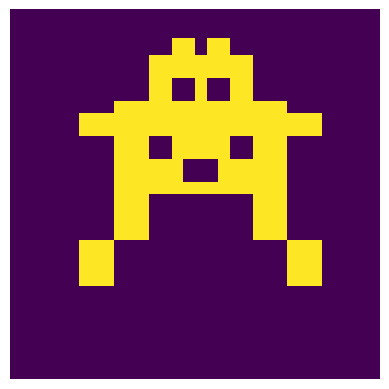

In [47]:
import torch
img = create_pixel_art()
plt.imshow(img)
plt.axis('off')
plt.show()
img_tensor = torch.from_numpy(img).float()


torch rfftn is a fast fourier transform in n dimensions. We use it for 2D tensore as an image.

In [51]:
from torch.fft import irfftn, rfftn
freqs = rfftn(img_tensor)
print(img_tensor.shape)
print(freqs.shape)


torch.Size([64, 64])
torch.Size([64, 33])


The output is the magnitude and phase of the frequency components of the image. Lets visualize all the magnitudes:

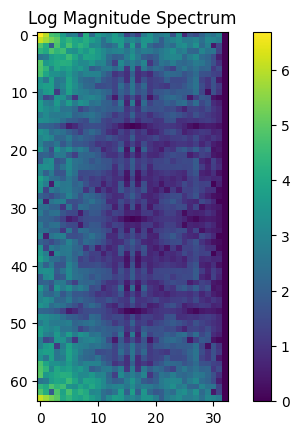

In [54]:
# Optional: visualize the magnitude spectrum
freq_magnitude = torch.abs(freqs)
plt.imshow(np.log1p(freq_magnitude.numpy()))
plt.colorbar()
plt.title("Log Magnitude Spectrum")
plt.show()

You can play around with the frequencies. For example you can try to reconstruct the input image by putting the frequencies with highest magnitude.

For example I defined `reconstruct_from_top_k` and I pass various values for k to it. The function will try to recounstruct the image from top 5 percent, top 10 percent ... of frequencies

In [57]:
total_components = len(flat_magnitudes)


total_components=2112


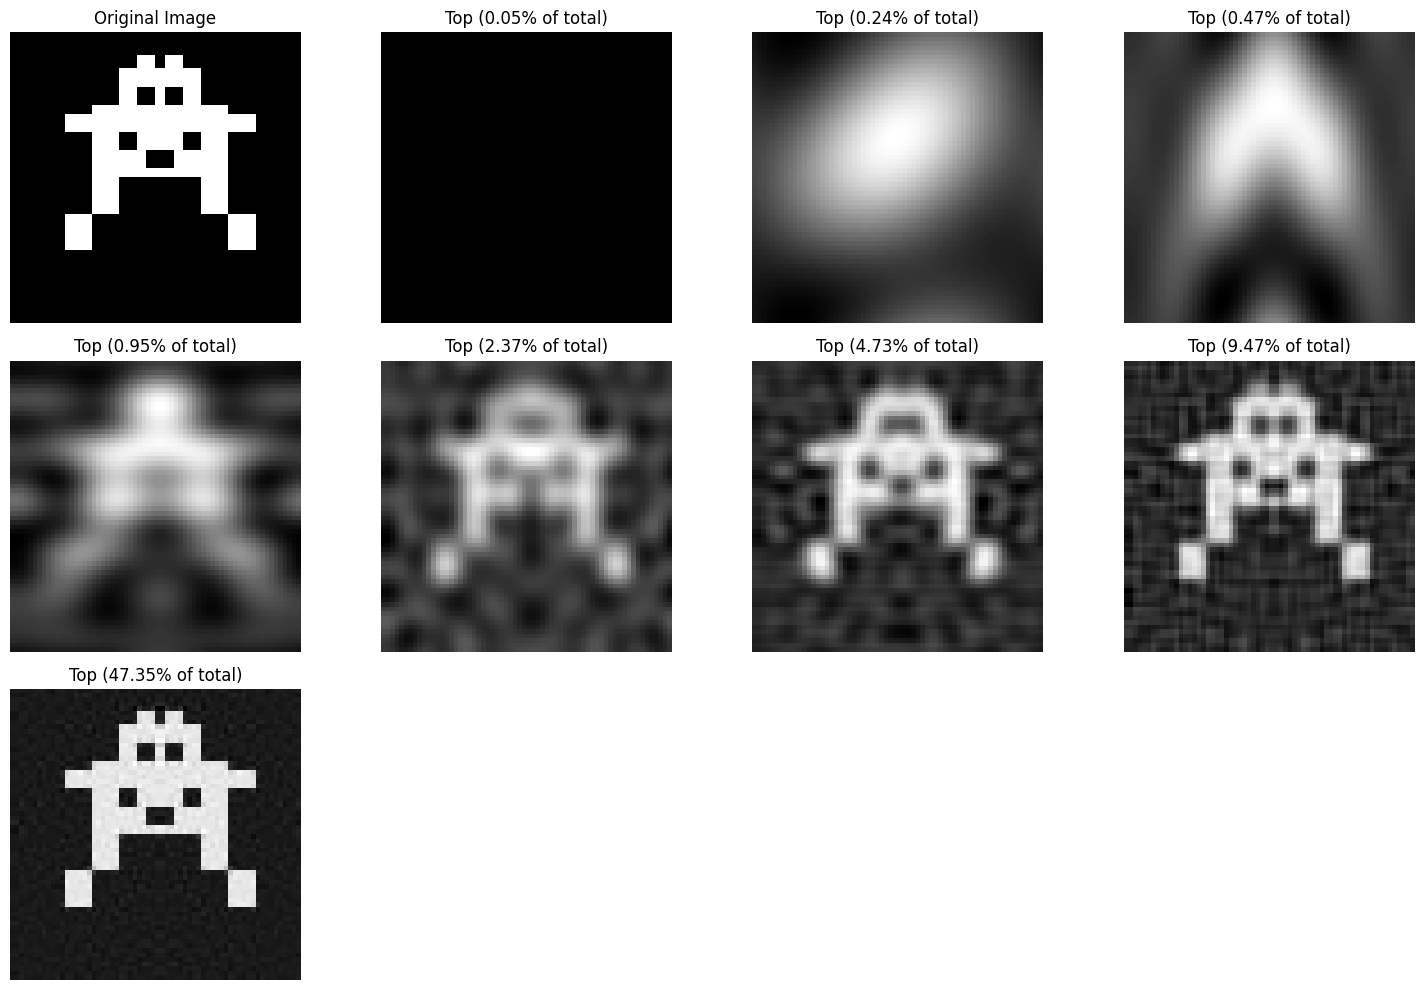

In [61]:
magnitudes = torch.abs(freqs)

# Flatten to find largest components
flat_magnitudes = magnitudes.flatten()
total_components = len(flat_magnitudes)
print(f'{total_components=}')
# Sort indices by magnitude (descending)
sorted_indices = torch.argsort(flat_magnitudes, descending=True)

# Define reconstruction function that uses top k components
def reconstruct_from_top_k(freqs, k, original_shape):
    # Start with zeros
    filtered_freqs = torch.zeros_like(freqs, dtype=torch.complex64)

    # Get the indices of the top k components
    top_k_indices = sorted_indices[:k]

    # Create mask of original shape
    mask = torch.zeros_like(flat_magnitudes, dtype=torch.bool)
    mask[top_k_indices] = True
    mask = mask.reshape(freqs.shape)

    # Copy only the top k components
    filtered_freqs[mask] = freqs[mask]

    # Convert back to spatial domain
    reconstructed = irfftn(filtered_freqs, s=original_shape)

    return reconstructed

component_counts = [1, 5, 10, 20, 50, 100, 200, 1000]

plt.figure(figsize=(15, 10))

# Original image
plt.subplot(3, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

#  reconstructions with different numbers of components
for i, k in enumerate(component_counts):
    reconstructed = reconstruct_from_top_k(freqs, k, img_tensor.shape)

    # Calculate what percentage of components we're using
    percentage = (k / total_components) * 100

    plt.subplot(3, 4, i+2)
    plt.imshow(reconstructed.numpy(), cmap='gray')
    plt.title(f'Top ({percentage:.2f}% of total)')
    plt.axis('off')

plt.tight_layout()
plt.show()



## Appendix

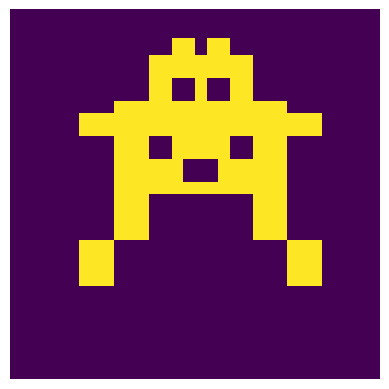

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create a fun pixel art image with more detail
def create_pixel_art(size=64):
    """Create a more detailed pixel art image"""
    # Start with blank canvas
    img = np.zeros((size, size))

    # Create a space invader
    if size >= 64:
        # Antenna
        img[5:8, 28:32] = 1
        img[5:8, 34:38] = 1

        # Head
        img[8:16, 24:42] = 1

        # Eyes
        img[12:16, 28:32] = 0
        img[12:16, 34:38] = 0

        # Body
        img[16:32, 18:48] = 1

        # Pattern in body
        img[22:26, 24:28] = 0
        img[22:26, 38:42] = 0
        img[26:30, 30:36] = 0

        # Arms
        img[18:22, 12:18] = 1
        img[18:22, 48:54] = 1

        # Legs
        img[32:40, 18:24] = 1
        img[32:40, 42:48] = 1
        img[40:48, 12:18] = 1
        img[40:48, 48:54] = 1
    else:
        # Simpler version for smaller sizes
        center = size // 2
        radius = size // 4

        # Head
        img[center-radius:center+radius, center-radius:center+radius] = 1

        # Eyes
        eye_size = max(2, size // 10)
        eye_offset = radius // 2
        img[center-eye_offset:center-eye_offset+eye_size,
            center-eye_offset:center-eye_offset+eye_size] = 0
        img[center-eye_offset:center-eye_offset+eye_size,
            center+eye_offset-eye_size:center+eye_offset] = 0

        # Mouth
        mouth_width = radius
        mouth_height = max(1, size // 16)
        img[center+radius//2:center+radius//2+mouth_height,
            center-mouth_width//2:center+mouth_width//2] = 0

    return img


In [28]:
def extract_basis_arrays(image, num_bases=25):
    """
    Extract the top basis functions from an image as a simple array.

    Args:
        image: 2D numpy array representing the input image
        num_bases: Number of basis functions to extract

    Returns:
        list of numpy arrays, each representing a basis function
        sorted by importance (magnitude)
    """
    height, width = image.shape

    # Compute FFT
    fft_result = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft_result)
    magnitude = np.abs(fft_shifted)

    # Create list of (magnitude, position, value) tuples
    components = []
    for i in range(height):
        for j in range(width):
            u = i - height // 2
            v = j - width // 2
            mag = magnitude[i, j]
            value = fft_shifted[i, j]
            components.append((mag, u, v, value))

    # Sort by magnitude (descending)
    components.sort(reverse=True)

    # Keep only the top components
    top_components = components[:num_bases]

    # Generate basis functions as simple arrays
    basis_arrays = []
    info = []

    for mag, u, v, value in top_components:
        # Create coordinates
        x = np.arange(width)
        y = np.arange(height)
        X, Y = np.meshgrid(x, y)

        # Get amplitude and phase
        amplitude = np.abs(value)
        phase = np.angle(value)

        # Create the basis function
        basis = amplitude * np.cos(2 * np.pi * (u * X / width + v * Y / height) + phase)

        # Store the basis function
        basis_arrays.append(basis)

        # Store metadata (optional)
        info.append({
            'magnitude': mag,
            'u': u,
            'v': v,
            'amplitude': amplitude,
            'phase': phase
        })

    return basis_arrays, info

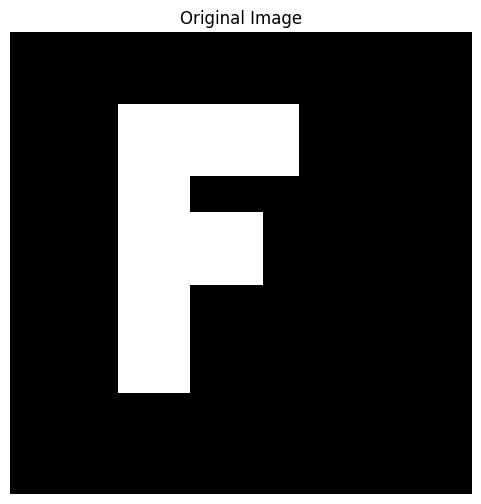

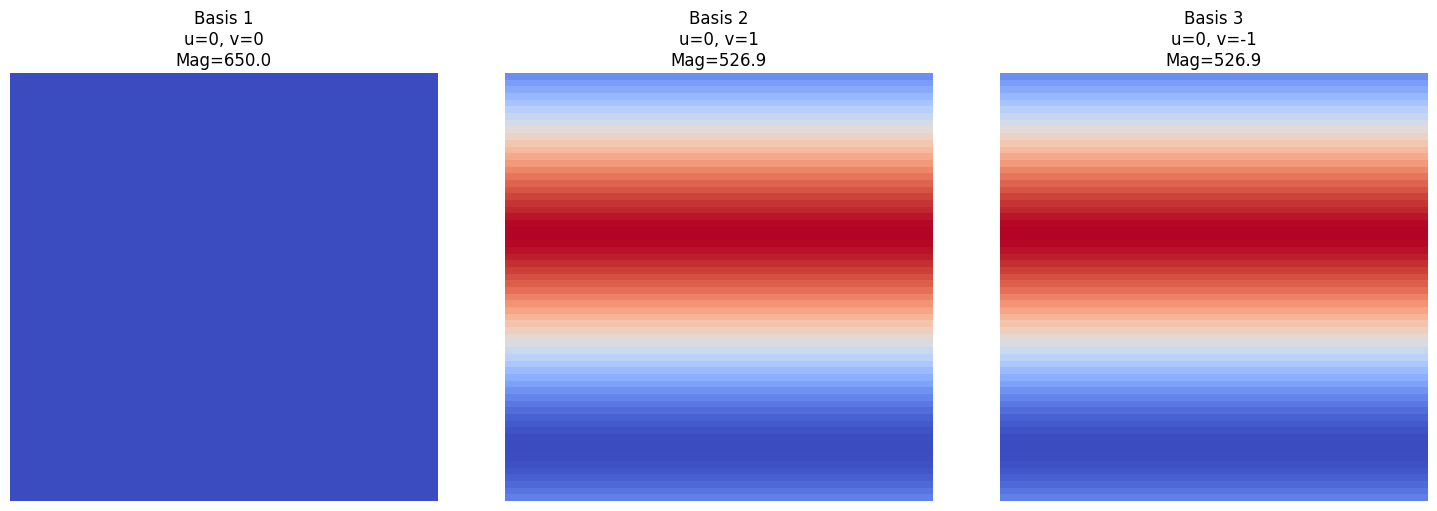

Manual reconstruction example:
img = b0.copy()
img += b1
img += b2


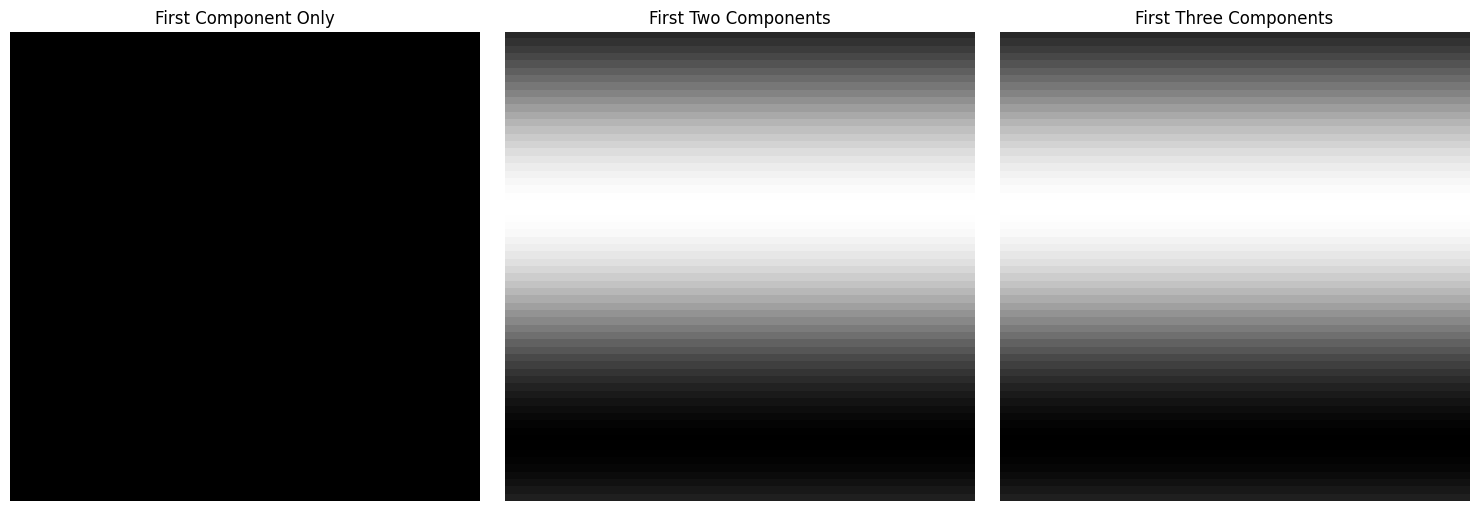

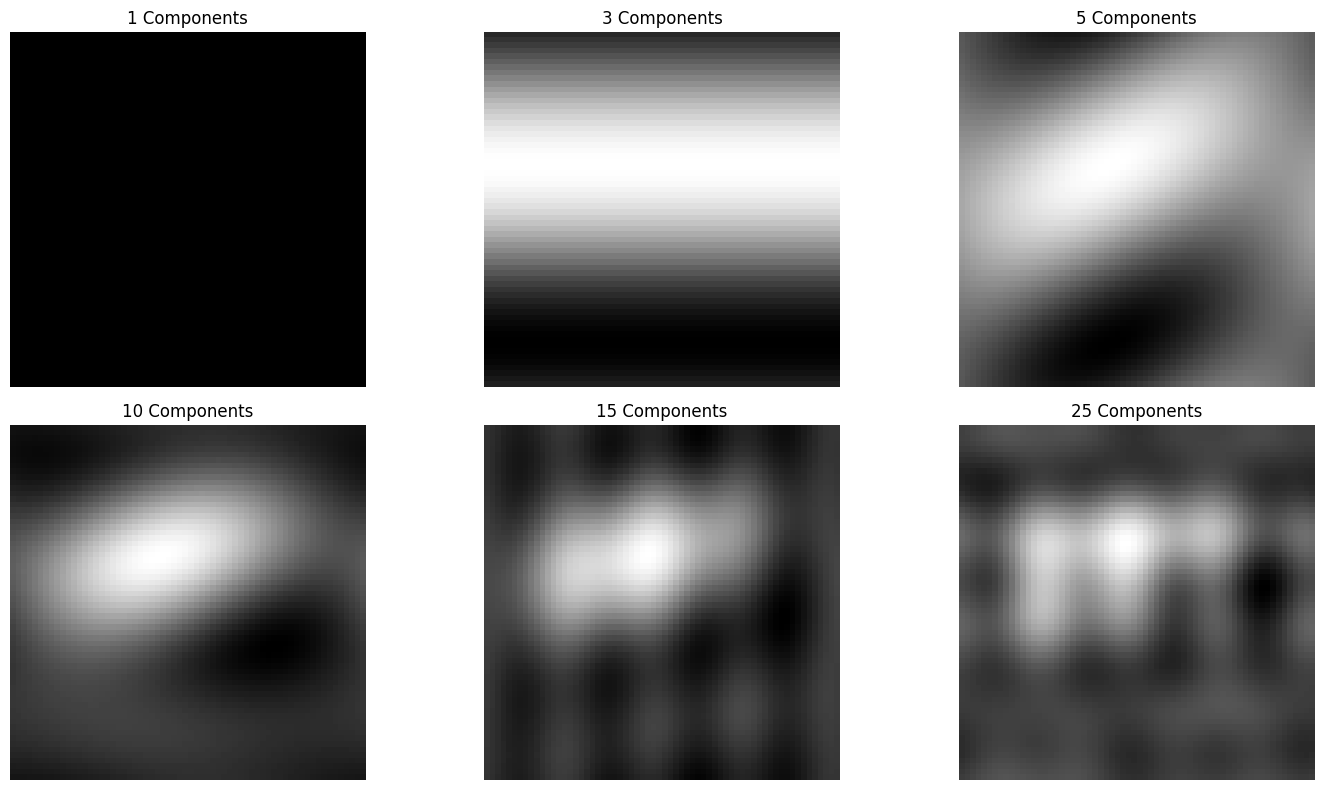

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def extract_basis_arrays(image, num_bases=25):
    """
    Extract the top basis functions from an image as a simple array.

    Args:
        image: 2D numpy array representing the input image
        num_bases: Number of basis functions to extract

    Returns:
        list of numpy arrays, each representing a basis function
        sorted by importance (magnitude)
    """
    height, width = image.shape

    # Compute FFT
    fft_result = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft_result)
    magnitude = np.abs(fft_shifted)

    # Create list of (magnitude, position, value) tuples
    components = []
    for i in range(height):
        for j in range(width):
            u = i - height // 2
            v = j - width // 2
            mag = magnitude[i, j]
            value = fft_shifted[i, j]
            components.append((mag, u, v, value))

    # Sort by magnitude (descending)
    components.sort(reverse=True)

    # Keep only the top components
    top_components = components[:num_bases]

    # Generate basis functions as simple arrays
    basis_arrays = []
    info = []

    for mag, u, v, value in top_components:
        # Create coordinates
        x = np.arange(width)
        y = np.arange(height)
        X, Y = np.meshgrid(x, y)

        # Get amplitude and phase
        amplitude = np.abs(value)
        phase = np.angle(value)

        # Create the basis function
        basis = amplitude * np.cos(2 * np.pi * (u * X / width + v * Y / height) + phase)

        # Store the basis function
        basis_arrays.append(basis)

        # Store metadata (optional)
        info.append({
            'magnitude': mag,
            'u': u,
            'v': v,
            'amplitude': amplitude,
            'phase': phase
        })

    return basis_arrays, info

# Example usage
if __name__ == "__main__":
    # Create a simple test image (e.g., a letter F)
    def create_letter_f(size=64):
        img = np.zeros((size, size))
        img[10:50, 15:25] = 1  # Vertical bar
        img[10:20, 15:40] = 1  # Top horizontal bar
        img[25:35, 15:35] = 1  # Middle horizontal bar
        return img

    # Create the test image
    test_image = create_letter_f(64)

    # Display the original image
    plt.figure(figsize=(6, 6))
    plt.imshow(test_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Extract basis functions as arrays
    basis_arrays, info = extract_basis_arrays(test_image, num_bases=25)

    # Now you can use them directly
    # b0 is the most important component, b1 is second, etc.
    b0 = basis_arrays[0]
    b1 = basis_arrays[1]
    b2 = basis_arrays[2]

    # Display the first few basis functions
    plt.figure(figsize=(15, 5))
    for i in range(min(3, len(basis_arrays))):
        plt.subplot(1, 3, i+1)
        plt.imshow(basis_arrays[i], cmap='coolwarm')
        plt.title(f"Basis {i+1}\nu={info[i]['u']}, v={info[i]['v']}\nMag={info[i]['magnitude']:.1f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Demonstrate manual reconstruction
    print("Manual reconstruction example:")
    print("img = b0.copy()")
    print("img += b1")
    print("img += b2")

    # Show progressive reconstruction
    plt.figure(figsize=(15, 5))

    # First component only
    img = b0.copy()
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("First Component Only")
    plt.axis('off')

    # First two components
    img += b1
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='gray')
    plt.title("First Two Components")
    plt.axis('off')

    # First three components
    img += b2
    plt.subplot(1, 3, 3)
    plt.imshow(img, cmap='gray')
    plt.title("First Three Components")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Progressive reconstruction with more components
    plt.figure(figsize=(15, 8))

    components_to_show = [1, 3, 5, 10, 15, 25]
    for i, n in enumerate(components_to_show):
        # Build image with n components
        img = np.zeros_like(test_image)
        for j in range(min(n, len(basis_arrays))):
            img += basis_arrays[j]

        plt.subplot(2, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{n} Components")
        plt.axis('off')

    plt.tight_layout()
    plt.show()